# Novozymes Enzyme Stability Prediction

[Kaggle](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/overview)

## Domain Info
Understanding and accurately predicting protein stability is a fundamental problem in biotechnology. Its applications include enzyme engineering for addressing the world’s challenges in sustainability, carbon neutrality, and more. Improvements to enzyme stability could lower costs and increase the speed scientists can iterate on concepts.

Novozymes invites you to develop a model **to predict/rank the thermal stability of enzyme variants based on experimental melting temperature data** obtained from Novozymes’s high throughput screening lab. You’ll have access to data from previous scientific publications. The available thermal stability data spans from natural sequences to engineered sequences with single or multiple mutations upon the natural sequences. If successful, you’ll help tackle the fundamental problem of improving protein stability, approaching design novel and useful proteins, like enzymes and therapeutics, more rapidly and at lower cost.

Enzymes are proteins that act as catalysts in the chemical reactions of living organisms. This competition’s goal is **to predict enzyme variants’ thermal stability.** The experimentally measured thermal stability (melting temperature) data includes **natural sequences and engineered sequences with single or multiple mutations upon the natural sequences**.



### Focus based in Domain Info
- Thermal stability
- Natural sequences / Engineered sequences
- single mutations / multiple mutations

### Amino acid flexibility change
- **W Y F C I V H L M A** being defined as rigid amino acids
- **G T R S N Q D P E K** being defined as flexible amino acids

## Import Module

In [1]:
# data processing
import numpy as np
import pandas as pd

# building neural network
import tensorflow as tf
from tensorflow.keras import layers

# evaluation metric
from scipy.stats import spearmanr

# train test split
from sklearn.model_selection import train_test_split

# visualization
from tensorflow.keras.utils import plot_model
import plotly.express as px
import plotly.graph_objects as go

# file navigation
import os

## Data Load

In [5]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/novozymes-enzyme-stability-prediction/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/kaggle/novozymes-enzyme-stability-prediction/test.csv')

In [6]:
df.columns

Index(['seq_id', 'protein_sequence', 'pH', 'data_source', 'tm'], dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [17]:
df.describe()

,seq_id,pH,tm
count,31390.000000,31104.000000,31390.000000
mean,15694.500000,6.892339,49.147337
std,9061.656811,1.612225,14.010089
min,0.000000,1.990000,-1.000000
25%,7847.250000,7.000000,42.100000
50%,15694.500000,7.000000,48.000000
75%,23541.750000,7.000000,53.800000
max,31389.000000,64.900000,130.000000


In [7]:
df.head(10)

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,doi.org/10.1038/s41592-020-0801-4,48.4
6,6,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,doi.org/10.1038/s41592-020-0801-4,45.7
7,7,AAENRPPIPGSLGMLYDSTLCVGCQACVTKCQDINFPERNPQGEQT...,7.0,doi.org/10.1038/s41592-020-0801-4,55.9
8,8,AAEYAVVLKTLSNPFWVDMKKGIEDEAKTLGVSVDIFASPSEGDFQ...,7.0,doi.org/10.1038/s41592-020-0801-4,48.1
9,9,AAFQVTSNEIKTGEQLTTSHVFSGFGCEGGNTSPSLTWSGVPEGTK...,7.0,doi.org/10.1038/s41592-020-0801-4,49.7


## Data Preprocessing

### Check Null Data

In [8]:
has_na = {}

for col in df.columns:
    has_na[col] = df[col].isnull().values.any()

print("Columns that contain null values:")

for col in has_na:
    if has_na[col]:
        print(col)

Columns that contain null values:
pH
data_source


- `pH`

In [9]:
null_ph_count = df['pH'].isna().sum()
null_ph_perc = null_ph_count / df.shape[0]

print(f"Missing {null_ph_count} pH values ({null_ph_perc:.2%})")

Missing 286 pH values (0.91%)


- `data_source`

In [11]:
null_ph_count = df['data_source'].isna().sum()
null_ph_perc = null_ph_count / df.shape[0]

print(f"Missing {null_ph_count} data_source values ({null_ph_perc:.2%})")

Missing 3347 data_source values (10.66%)


In [14]:
# delete data_source column
df = df.drop('data_source', axis=1)

df

,seq_id,protein_sequence,pH,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...,...
31385,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
31386,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
31387,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6
31388,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7


### Feature Engineering

In [56]:
# We only include non-zero 1-letter sequence code in the feature extraction
Letter_1_Seq = []

for i in Protein_Seq:
    if i not in Null_Seq:
        Letter_1_Seq.append(i)

print('1-letter Protein Sequence : {}'.format(Letter_1_Seq))

print('Size of training and testing dataset before extracting 1-letter sequence: {} and {}'.format(df.shape, df_test.shape))

for col in Letter_1_Seq:
#     print('{}: {}'.format(col, df_train['protein_sequence'].str.contains(col).sum()))
    df[col] = df['protein_sequence'].str.count(col)
    df_test[col] = df_test['protein_sequence'].str.count(col)
    
print('Size of training and testing dataset after extracting 1-letter sequence: {} and {}'.format(df.shape, df_test.shape))

1-letter Protein Sequence : ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Size of training and testing dataset before extracting 1-letter sequence: (31390, 24) and (2413, 24)
Size of training and testing dataset after extracting 1-letter sequence: (31390, 24) and (2413, 24)


In [57]:
df.head(10)

,seq_id,protein_sequence,pH,tm,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,45,1,13,30,13,38,...,8,5,18,6,25,11,14,37,4,3
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,28,0,10,52,6,18,...,2,6,8,22,30,14,12,13,3,3
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,50,9,27,32,21,65,...,6,15,20,25,31,33,30,30,3,16
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,20,5,19,29,12,16,...,2,9,16,9,10,16,19,14,3,4
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,86,14,78,78,32,84,...,31,65,128,54,63,148,120,124,16,47
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,33,4,16,19,16,33,...,11,13,19,8,16,22,25,41,10,9
6,6,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,45.7,33,4,16,19,16,33,...,11,13,19,8,17,22,25,41,10,9
7,7,AAENRPPIPGSLGMLYDSTLCVGCQACVTKCQDINFPERNPQGEQT...,7.0,55.9,15,16,18,17,3,28,...,6,18,21,11,10,11,18,23,2,17
8,8,AAEYAVVLKTLSNPFWVDMKKGIEDEAKTLGVSVDIFASPSEGDFQ...,7.0,48.1,41,1,19,16,9,25,...,8,16,10,9,6,14,13,28,3,4
9,9,AAFQVTSNEIKTGEQLTTSHVFSGFGCEGGNTSPSLTWSGVPEGTK...,7.0,49.7,14,2,7,7,7,20,...,1,7,12,4,3,11,17,14,5,6


In [58]:
Protein_Seq = Letter_1_Seq

### Standardization for numerical labels

In [60]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [62]:
standardScaler = StandardScaler()
encoder_num = standardScaler.fit_transform(df[Protein_Seq])
encoded_num = pd.DataFrame(encoder_num, columns =Protein_Seq)

print(encoded_num.shape)
print(encoded_num.head(5))

(31390, 20)
          A         C         D         E         F         G         H  \
0  0.244496 -0.439194 -0.336847 -0.045082 -0.179808  0.198720 -0.540171   
1 -0.143868 -0.517543 -0.421907  0.336342 -0.531209 -0.294110 -0.463664   
2  0.358721  0.187599  0.060101 -0.010407  0.221794  0.864041  0.071886   
3 -0.326628 -0.125798 -0.166726 -0.062420 -0.230008 -0.343393 -0.234143   
4  1.181140  0.579344  1.506126  0.787116  0.773996  1.332230  2.290593   

          I         K         L         M         N         P         Q  \
0 -0.266988 -0.243011 -0.095033 -0.206285 -0.550394 -0.100751 -0.467290   
1 -0.294322 -0.183255 -0.362918 -0.743014 -0.510646 -0.323040  0.089106   
2 -0.212321  0.215114 -0.458592 -0.385195 -0.152912 -0.056293  0.193430   
3 -0.376323 -0.223092 -0.267245 -0.743014 -0.391401 -0.145209 -0.362966   
4  1.291032  0.792749  1.186989  1.851177  1.834498  2.344428  1.201898   

          R         S         T         V         W         Y  
0  0.037342 -0.420282 

## Simple EDA

[Spearman Correlation](https://www.kaggle.com/code/jbomitchell/spearman-correlation-of-public-models)

### Protein Sequence

- Count of amino acid

In [15]:
# count of amino acid
amino_count = df['protein_sequence'].str.split('').explode('protein_sequence').value_counts().drop('')

amino_count

L    1317330
A    1076601
E    1023323
S    1010021
G     939677
V     918075
K     885207
D     780992
T     758905
I     746069
R     745753
P     707293
Q     610147
N     591608
F     520503
Y     416436
M     323506
H     315796
C     207350
W     157754
Name: protein_sequence, dtype: int64

In [20]:
# 0 count of amino acid
Protein_Seq = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Null_Seq = []

for col in Protein_Seq:
    if df['protein_sequence'].str.contains(col).sum() == 0 :
        print('{}: {}'.format(col, df['protein_sequence'].str.contains(col).sum()))
        Null_Seq.append(col)
        
print('Sequence with no occurence : {}'.format(Null_Seq))    

B: 0
J: 0
O: 0
U: 0
X: 0
Z: 0
Sequence with no occurence : ['B', 'J', 'O', 'U', 'X', 'Z']


In [16]:
# graph of amino acid
fig = px.bar(amino_count, x=amino_count.index, y='protein_sequence', color=amino_count.index)
fig.update_layout(
    title='Amino Acid Count',
    height=600,
    template='ggplot2'
)

fig.show()

- Length of amino acid

In [21]:
# length of amino acid
sequence_length = df['protein_sequence'].str.len()

sequence_length

0         341
1         286
2         497
3         265
4        1451
         ... 
31385     549
31386     469
31387     128
31388     593
31389     537
Name: protein_sequence, Length: 31390, dtype: int64

In [29]:
def plot_histo_with_tot_count(series, title):
    fig = px.histogram(series)
    fig.add_annotation(
        x=0.95,
        y=0.95,
        xref='paper',
        yref='paper',
        text="Total Count = {:,}".format(series.size),
        showarrow=False
    )
    fig.update_layout(title=title, showlegend=False, template='ggplot2')
    return fig

In [30]:
# wide graph
fig = plot_histo_with_tot_count(
    series=sequence_length,
    title='Sequence Length Count'
)

fig.show()

In [31]:
# detail graph
fig = plot_histo_with_tot_count(
    series=sequence_length[sequence_length <= 1024],
    title='Sequence Length Count (Max Length = 1024)'
)

fig.show()

**Output**

We could **drop sequences where the sequence_length > 1024**, and get a simpler model, since the number of sequences with length greater than that is so small.

### pH Level

In [26]:
px.histogram(df, x='pH', title='pH Count', template='ggplot2')

**Output**

pH Level spectrum is from 0~14. So **drop pH values greater than 14**, since they're probably a mistake.

In [27]:
px.histogram(df[df['pH'] <=14], x='pH', title='pH Count (less than 14)', template='ggplot2')

### tm

In [28]:
px.histogram(df, x='tm', title="tm Distribution", template='ggplot2')

Output

There seems to be a "natural" distribution with mean around ~50 and **some spikes at 5, 10, 15, 20 and 25**.

## 3D EDA

[Structure Difference](https://www.kaggle.com/code/cdeotte/difference-features-lb-0-600)

### Wildtype structure prediction

- Using biopandas

In [32]:
!pip install biopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 878 kB 14.7 MB/s 


In [41]:
from biopandas.pdb import PandasPdb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [34]:
ppdb = PandasPdb().read_pdb('/content/drive/MyDrive/kaggle/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb')

In [35]:
ppdb.df.keys()

dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])

In [36]:
df_hetatm=ppdb.df["HETATM"].shape
df_anistropic=ppdb.df["ANISOU"].shape
df_others=ppdb.df["OTHERS"].shape

print ("shape of hetatm",df_hetatm)
print("shape of ansiou",df_anistropic)
print("shape of others",df_others)

shape of hetatm (0, 21)
shape of ansiou (0, 21)
shape of others (2, 3)


In [38]:
df_atom = ppdb.df["ATOM"]

df_atom

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,VAL,,A,1,,...,34.064,-6.456,50.464,1.0,45.11,,,N,NaN,0
1,ATOM,2,,H,,VAL,,A,1,,...,33.576,-6.009,51.228,1.0,45.11,,,H,NaN,1
2,ATOM,3,,H2,,VAL,,A,1,,...,33.882,-7.449,50.477,1.0,45.11,,,H,NaN,2
3,ATOM,4,,H3,,VAL,,A,1,,...,35.060,-6.323,50.566,1.0,45.11,,,H,NaN,3
4,ATOM,5,,CA,,VAL,,A,1,,...,33.643,-5.877,49.162,1.0,45.11,,,C,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,ATOM,3313,,NZ,,LYS,,A,221,,...,4.616,13.323,-4.301,1.0,93.80,,,N,NaN,3312
3313,ATOM,3314,,HZ1,,LYS,,A,221,,...,5.270,12.565,-4.432,1.0,93.80,,,H,NaN,3313
3314,ATOM,3315,,HZ2,,LYS,,A,221,,...,4.585,13.517,-3.310,1.0,93.80,,,H,NaN,3314
3315,ATOM,3316,,HZ3,,LYS,,A,221,,...,4.965,14.143,-4.776,1.0,93.80,,,H,NaN,3315


In [39]:
df_atom.shape

(3317, 21)

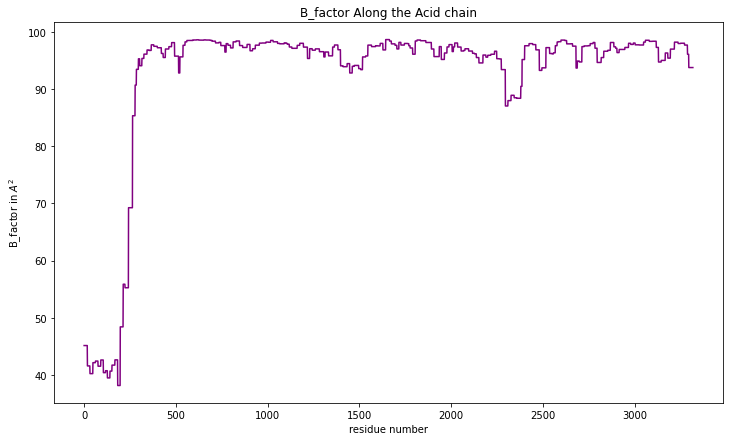

In [42]:
ppdb.df["ATOM"]["b_factor"].plot(kind="line",color="purple",figsize=(12,7))
plt.title("B_factor Along the Acid chain")
plt.xlabel("residue number")
plt.ylabel("B_factor in $A^2$")

plt.show()

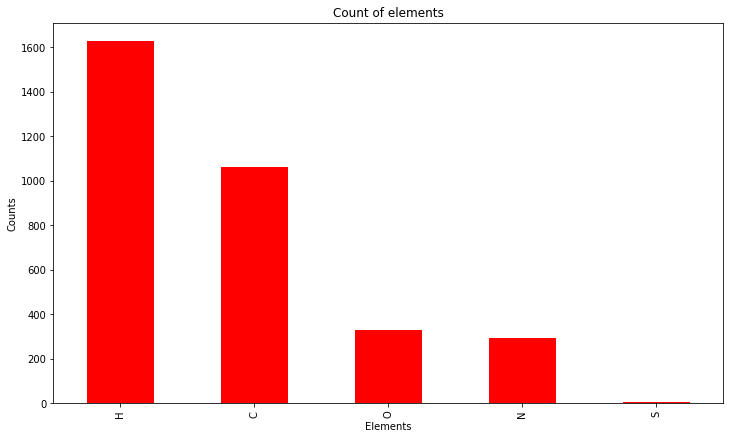

In [43]:
ppdb.df["ATOM"]["element_symbol"].value_counts().plot(kind="bar",color="red",figsize=(12,7))
plt.title("Count of elements")
plt.xlabel("Elements")
plt.ylabel("Counts")

plt.show()

In [44]:
mainchain=ppdb.df["ATOM"][(ppdb.df["ATOM"]['atom_name']=="C")|(["atom_name"]=="O")|(["atom_name"]=="N")|(["atom_name"]=="CA")]
bfactor_mc_ave=mainchain["b_factor"].mean()

print("average temp of main-chain",bfactor_mc_ave)

average temp of main-chain 92.41787330316741


- Amino acid element

In [46]:
fig=px.scatter_3d(df_atom,x="x_coord",y="y_coord",z="z_coord",color="element_symbol",template="plotly_dark")
fig.update_coloraxes(showscale=True)
fig.update_traces(marker=dict(size=3))

fig.show()

- Amino acid residue

In [48]:
fig=px.scatter_3d(df_atom,x="x_coord",y="y_coord",z="z_coord",color="residue_name",template="plotly_dark")
fig.update_traces(marker=dict(size=3))
fig.update_coloraxes(showscale=True)

fig.show()

- Amino acid atom

In [47]:
fig=px.scatter_3d(df_atom,x="x_coord",y="y_coord",z="z_coord",color="atom_name",template="plotly_dark")
fig.update_traces(marker=dict(size=3))
fig.update_coloraxes(showscale=True)

fig.show()

## Model Training

- **XGBooster**

In [66]:
from sklearn.model_selection import train_test_split
import xgboost

In [63]:
X = encoded_num.copy()
y = df['tm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [10, 15, 20, 25],
        'min_child_weight': [5, 10, 20, 30],
        'subsample': [0.3, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'n_estimators' : [500], # , 500, 750, 1000
        'objective': ['reg:squarederror']
    }
    
    xgb_model = xgboost.XGBRegressor()

    gsearch = RandomizedSearchCV(estimator = xgb_model,
                           param_distributions = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 3,
                           n_iter=35, 
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [67]:
model_XGBoost = xgboost.XGBRegressor(n_estimators=500, max_depth=15, learning_rate= 0.001)

model_XGBoost.fit(X_train, y_train)

print('Model model_XGBoost Training is done!')

[07:54:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model model_XGBoost Training is done!


- Correlation Coefficient

In [68]:
from scipy import stats

y_pred_xgboost = model_XGBoost.predict(X_test)

stats.spearmanr(y_test, y_pred_xgboost)

SpearmanrResult(correlation=0.4950075621460116, pvalue=0.0)

In [69]:
print(y_pred_xgboost)
print(y_test)

[19.712463 19.000004 19.367414 ... 19.380556 33.706608 24.575161]
7891     43.0
30093    43.1
27408    51.5
11544    39.1
21495    46.9
         ... 
6062     45.6
18632    66.7
28266    61.8
29385    85.2
19612    62.5
Name: tm, Length: 9417, dtype: float64


## Prediction

In [70]:
df_pred = df_test.copy()

encoded_num = standardScaler.transform(df_pred[Protein_Seq])

df_pred = pd.DataFrame(encoded_num, columns =Protein_Seq)

print(df_pred.head(5))

          A         C        D         E         F         G         H  \
0 -0.280938 -0.204147 -0.28014 -0.426507 -0.330408 -0.269469 -0.769692   
1 -0.280938 -0.204147 -0.28014 -0.443844 -0.330408 -0.269469 -0.769692   
2 -0.280938 -0.204147 -0.28014 -0.443844 -0.330408 -0.269469 -0.769692   
3 -0.280938 -0.125798 -0.28014 -0.443844 -0.330408 -0.269469 -0.769692   
4 -0.280938 -0.204147 -0.28014 -0.443844 -0.280208 -0.269469 -0.769692   

          I         K         L         M         N        P         Q  \
0 -0.485657 -0.083663 -0.611669 -0.921924  0.006081 -0.12298 -0.223867   
1 -0.485657 -0.063745 -0.611669 -0.921924  0.006081 -0.12298 -0.223867   
2 -0.485657 -0.083663 -0.611669 -0.921924  0.006081 -0.12298 -0.223867   
3 -0.485657 -0.103582 -0.592534 -0.921924  0.006081 -0.12298 -0.223867   
4 -0.485657 -0.103582 -0.592534 -0.921924  0.006081 -0.12298 -0.223867   

          R         S         T         V         W         Y  
0 -0.623928 -0.281355 -0.368168 -0.306211  0.1

In [71]:
submission = pd.DataFrame()
submission['seq_id'] = df_test['seq_id']
submission['tm'] =model_XGBoost.predict(df_pred)

print(submission.head(10))

submission.to_csv("submission.csv", index=False)
print('Submission Done')

   seq_id         tm
0   31390  19.416430
1   31391  19.416430
2   31392  19.416430
3   31393  19.546490
4   31394  19.546490
5   31395  19.546490
6   31396  19.546490
7   31397  19.482744
8   31398  19.416430
9   31399  19.416430
Submission Done


## Public Score

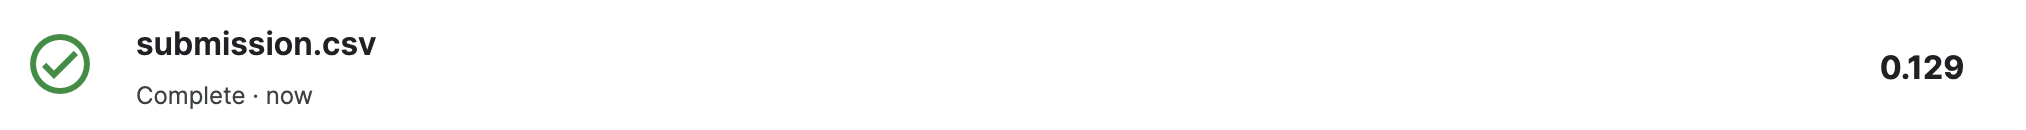